In [1]:
import IPython.display as disp
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from collections import Counter

## Bayes formula

\begin{equation}
P(\theta|D)=\frac{P(D|\theta)P(\theta)}{P(D)}
\end{equation}

$ P(\theta|D) $ — probability of hypothesis, given data $\theta$ 

$ P(D|\theta) $ — proabability of data, if hypothesis is true

$ P(D) $ — normalising constant (probability of data $\theta$ 

$ P(\theta) $ — prior probability of data

Let's calculate our example with desease test

$ P(\theta|D) $ — patient is sick, given test is positive

$ P(D|\theta) $ — test is positive, if patient is sick. As our test's reliability is 99%, this equals 0.99

$ P(D) $ — probability of positive test in any case. It's a sum of "true positives" (99% for 1% of people) 0.99 * 0.01 = 0.0099 and "false positives" (1% for 99% of people) 0.01 * 0.99 = 0,0099 

$ P(\theta) $ — patient is positive, as this probability is 1%, this will be 0.01

$$ P(sick|test+) = \frac{0.99 * 0.01}{0.0099 + 0.0099} = \frac{0.0099}{0,0198} = \frac{1}{2} $$ 

In [2]:
class BIM():    
    def __init__(self, hypotheses, priors, likelihood_func):
        self._hyps = np.array(hypotheses)
        self._probs = np.array(priors)
        self._like_func = likelihood_func
        
    def update(self, data):
        # update probabilities
        self._probs = np.array([probability * self._like_func(hypothesis, data) 
                                for hypothesis, probability in zip(self._hyps, self._probs)])
        # normalise
        self._probs = self._probs / np.sum(self._probs)
    
    def __str__(self):
        probs = ", ".join(f"{hyp}: {prob}" for hyp, prob in zip(self._hyps, self._probs))
        return f"BIM ({probs})"
    
    def plot(self, **options):
        plt.plot(self._hyps, self._probs, **options)
        
    def pick_random_hypothesis(self):
        return np.random.choice(self._hyps, p=self._probs)
    
    def mean(self):
        return np.sum(self._probs * self._hyps)

In [3]:
def vases_likelihood(hypotesis, data):
    probabilities = {"First": {"Vanilla": 0.75, "Chocolate": 0.25}, "Second": {"Vanilla": 0.5, "Chocolate": 0.5}}
    return probabilities[hypotesis][data]

two_vases = BIM(["First", "Second"], [0.5, 0.5], vases_likelihood)

str(two_vases)

'BIM (First: 0.5, Second: 0.5)'

In [4]:
two_vases.update("Vanilla")

str(two_vases)

'BIM (First: 0.6, Second: 0.4)'

In [5]:
two_vases.update("Vanilla")

str(two_vases)

'BIM (First: 0.6923076923076923, Second: 0.30769230769230776)'

In [6]:
two_vases2 = BIM(["First", "Second"], [0.5, 0.5], vases_likelihood)

vanilla_button = widgets.Button(description="Vanilla")
chocolate_button = widgets.Button(description="Chocolate")
outp = widgets.Output()

def button_clicked(btn):
    two_vases2.update(btn.description)
    with outp:
        print(str(two_vases2))
    
vanilla_button.on_click(button_clicked)
chocolate_button.on_click(button_clicked)

widgets.VBox([widgets.HBox([vanilla_button, chocolate_button]), outp])

In [7]:
cubes = [4, 6, 8, 12, 16]

def cubes_likelihood(hypotesis, data):
    return 0 if data>hypotesis else 1/hypotesis

cubes_test = BIM(cubes, [1/len(cubes)] * len(cubes), cubes_likelihood)

str(cubes_test)

'BIM (4: 0.2, 6: 0.2, 8: 0.2, 12: 0.2, 16: 0.2)'

In [8]:
val_slider = widgets.IntSlider(value=3, min=1, max=16, description='Dice roll:', readout=True, readout_format='d')
roll_button = widgets.Button(description="Roll!")
outp = widgets.Output()

def update_info():
    with outp:
        disp.clear_output(wait=True)
        print(str(cubes_test))

def button_click(_):
    cubes_test.update(val_slider.value)
    update_info()
    
roll_button.on_click(button_click)

update_info()
widgets.VBox([val_slider, roll_button, outp])

## Ad banner model

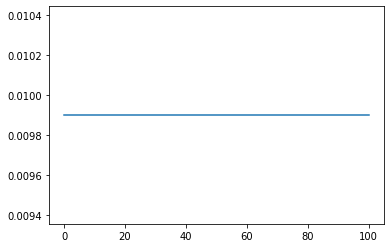

In [9]:
def likelihood_banner(hypotesis, data):
    """Likelihood function for ad banner model
    
    hypotesis: probability of click (0-100)
    data: bool, showing the win
    
    returns: float probability
    """
    x = hypotesis / 100
    if data:
        return x
    else:
        return 1-x
    

banner = BIM(list(range(101)), [1/101] * 101, likelihood_banner)
banner.plot()

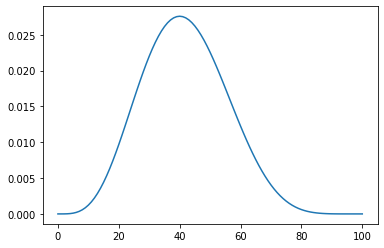

In [10]:
sample_data = [False, False, False, True, True, False, False, True, False, True]

for dat in sample_data:
    banner.update(dat)
    
banner.plot()

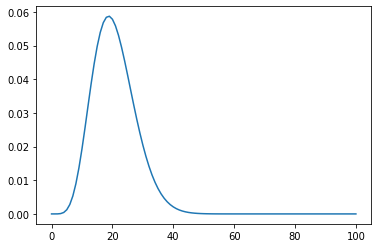

In [11]:
more_samples = [True] * 2 + [False] * 20

for dat in more_samples:
    banner.update(dat)
    
banner.plot()

In [12]:
def win_given_probability(prob):
    return np.random.rand() < prob

[win_given_probability(0.5) for _ in range(10)]

[True, False, False, True, False, False, False, False, False, True]

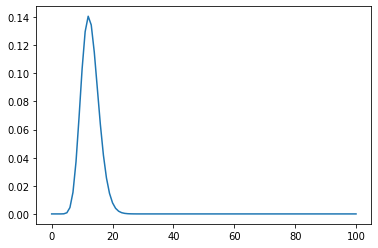

In [13]:
for _ in range(100):
    banner.update(win_given_probability(0.15))
    
banner.plot()

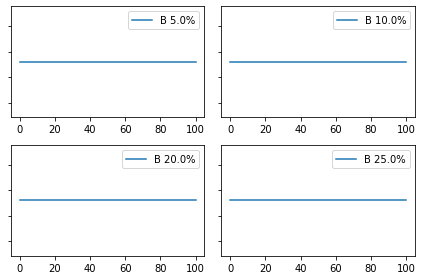

In [14]:
test_probs = [0.05, 0.1, 0.2, 0.25]

class BannerModel:
    def __init__(self, actual_prob):
        self.actual_prob = actual_prob
        self._bim = BIM(list(range(101)), [1/101] * 101, likelihood_banner)
        
    def show(self):
        outcome = win_given_probability(self.actual_prob)
        self._bim.update(outcome)
        return outcome
        
    def plot(self, **kwargs):
        self._bim.plot(**kwargs)
        
    def pick_random(self):
        return self._bim.pick_random_hypothesis()
    
    def mean(self):
        return self._bim.mean()
        
all_banners = [BannerModel(prob) for prob in test_probs]

def plot_all(banners, **options):
    for idx, banner in enumerate(banners):
        plt.subplot(2, 2, idx+1)
        banner.plot(label=f'B {banner.actual_prob * 100}%')
        plt.gca().set_yticklabels([])
        plt.legend()
        
    plt.tight_layout()
    
    
plot_all(all_banners)

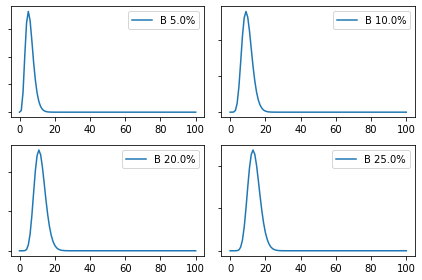

In [15]:
for banner in all_banners:
    for _ in range(100):
        banner.show()
        
plot_all(all_banners)

In [16]:
def chose_best_one(all_banners):
    return np.argmax([ban.pick_random() for ban in all_banners])

def pick_and_show(all_banners, verbose=False):
    best = chose_best_one(all_banners)
    best_banner = all_banners[best]
    outcome = best_banner.show()
    
    if verbose:
        print(f"We picked {best} and got {outcome}. Mean now is {best_banner.mean()}")
        
    return best
        
pick_and_show(all_banners, verbose=True)

We picked 3 and got False. Mean now is 13.5922330096654


3


0 20
1 72
2 120
3 788


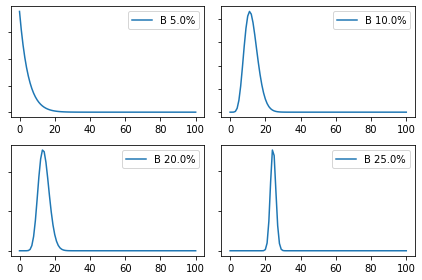

In [17]:
all_banners = [BannerModel(prob) for prob in test_probs]

sel_counter = Counter()
for _ in tqdm(range(1000)):
    selected = pick_and_show(all_banners)
    sel_counter[selected] += 1

for banner, count in sorted(sel_counter.items()):
    print(banner, count)   
    
plot_all(all_banners)